In this notebook, we're going to analyze electric power production based on data with a timestamp every 15 minutes. We will also try to predict this time series.

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
import pmdarima as pm
import prophet

import statsmodels.api as sm

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

In [43]:
df = pd.read_csv('./../data/data.csv')
df.head()

,dt,MW
0,2011-01-01 00:00:00,3416.0
1,2011-01-01 00:15:00,4755.0
2,2011-01-01 00:30:00,4939.0
3,2011-01-01 00:45:00,4939.0
4,2011-01-01 01:00:00,4998.0


In [44]:
df['dt'] = pd.to_datetime(df['dt'])

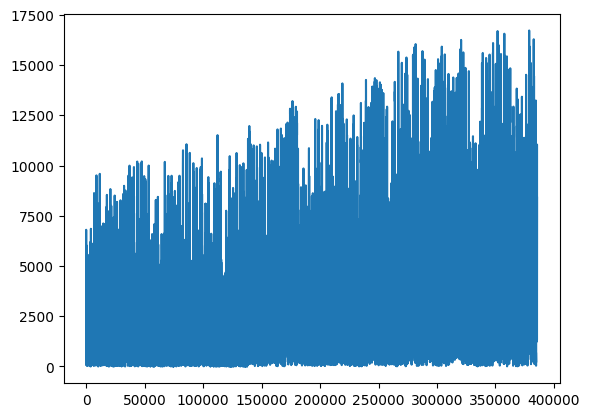

In [45]:
plt.plot(df['MW'])
plt.show()

The first thing that can be noticed: the series is not stationary and looks as if there is some kind of seasonality. But there are very many observations, and it makes sense to group by sum of days (not every 15 minutes). Grouping by sum, as the observations are the amount of energy produced in 15 minutes.

In [99]:
electricity = df.copy()
electricity['dt'] = electricity['dt'].dt.date
el_gr = electricity.groupby('dt').agg({'MW': 'sum'})

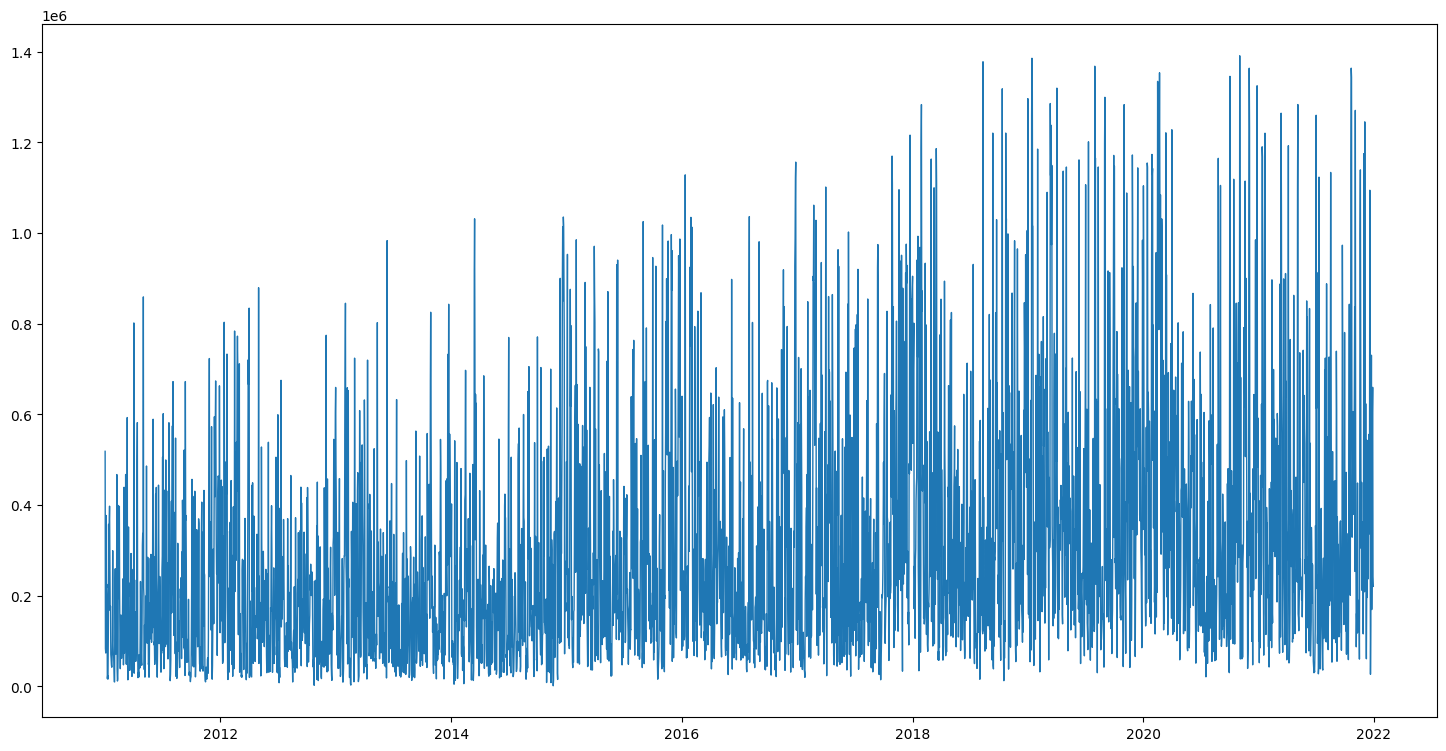

In [100]:
plt.figure(figsize=(18, 9))
plt.plot(el_gr['MW'], linewidth=1)
plt.show()

Here a small trend is noticed

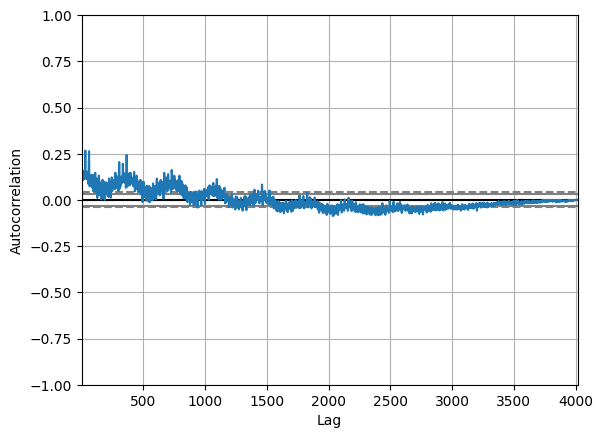

In [59]:
pd.plotting.autocorrelation_plot(el_gr['MW'])
plt.show()

The chart shows the presence of, albeit small, seasonality, and if you pay attention to the periodicity, it can be seen that the length of the period is equal to a year or 365 days. Let's check the correlation with lag=365 and lag=30.

In [101]:
el_gr['MW'].autocorr(lag=365)

0.2672600538283913

In [102]:
el_gr['MW'].autocorr(lag=30)

0.23992254951049477

In both cases, there is a correlation.

In [103]:
adfuller(el_gr['MW'])[1]

6.4090573667228544e-06

According to the statistical test, it can be judged that the series is stationary. Although in reality we have a small trend, so I would say that the series is more non-stationary.

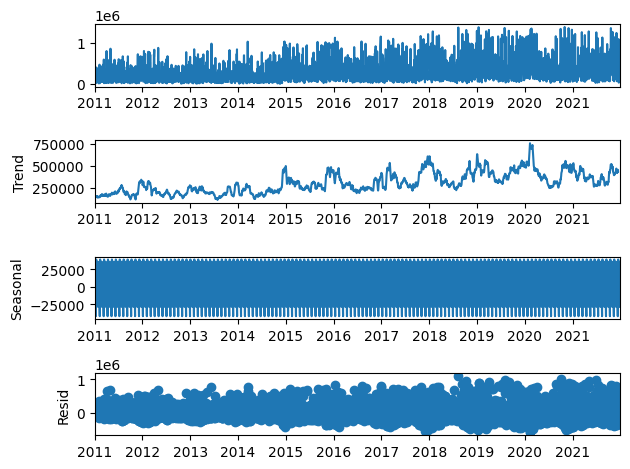

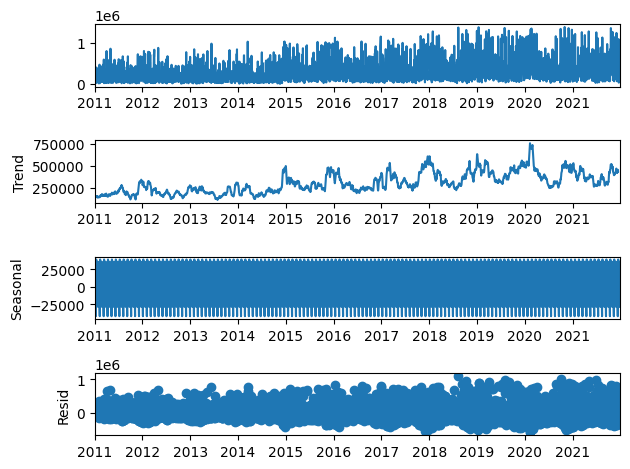

In [62]:
sd = seasonal_decompose(el_gr, period=30)
sd.plot()

As the series, in my opinion, is more non-stationary and there is seasonality present, it makes sense to apply the SARIMA model.

In [63]:
N_test = 365
train = el_gr.iloc[:-N_test]
test = el_gr.iloc[-N_test:]

In [66]:
model = pm.auto_arima(train['MW'],
                      trace=True,
                      suppress_warnings=True,
                      seasonal=True,
                      m=12,
                      # start_p=10,
                      # start_q=10,
                      # max_p=50,
                      # max_q=50,
                      # d=1,
                      # max_d=30
                      random=True)

model.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=100446.697, Time=12.78 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=101752.558, Time=0.15 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=101239.639, Time=1.24 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=100845.205, Time=3.02 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=101750.558, Time=0.10 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=100446.337, Time=8.81 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=100444.674, Time=3.72 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=100446.389, Time=9.31 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=100442.100, Time=1.89 sec
 ARIMA(1,1,2)(1,0,0)[12] intercept   : AIC=100443.906, Time=4.70 sec
 ARIMA(1,1,2)(0,0,1)[12] intercept   : AIC=100443.738, Time=5.62 sec
 ARIMA(1,1,2)(1,0,1)[12] intercept   : AIC=100438.771, Time=8.26 sec
 ARIMA(1,1,2)(2,0,1)[12] intercept   : AIC=100440.771, Time=28.44 sec
 ARIMA(1,1,2)(1,0,2)[12] intercept   : AIC=100440.766, Tim

KeyboardInterrupt: 

Something happened and the training is taking a very long time, before it all took 3 minutes and the parameters (2, 1, 1)(1, 0, 0) were obtained.

In [36]:
test_predictions, confidence_interval = model.predict(n_periods=N_test, return_conf_int=True)

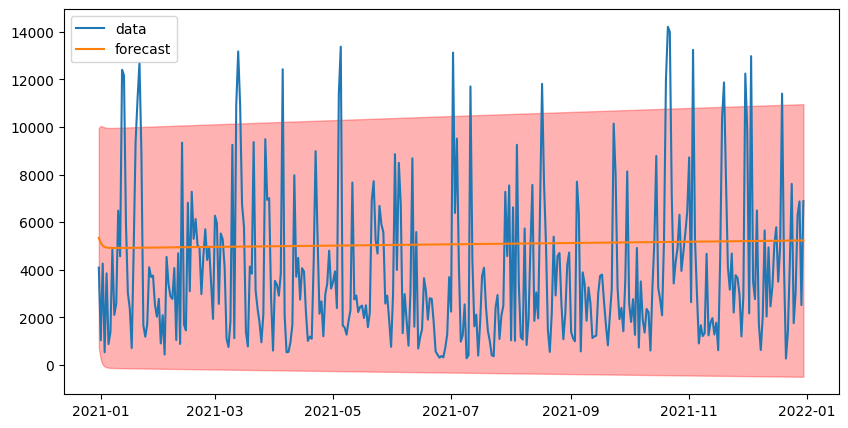

In [38]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(test.index, test['MW'], label='data')
ax.plot(test.index, test_predictions, label='forecast')
ax.fill_between(test.index, confidence_interval[:,0], confidence_interval[:, 1], color='red', alpha=0.3)
ax.legend();

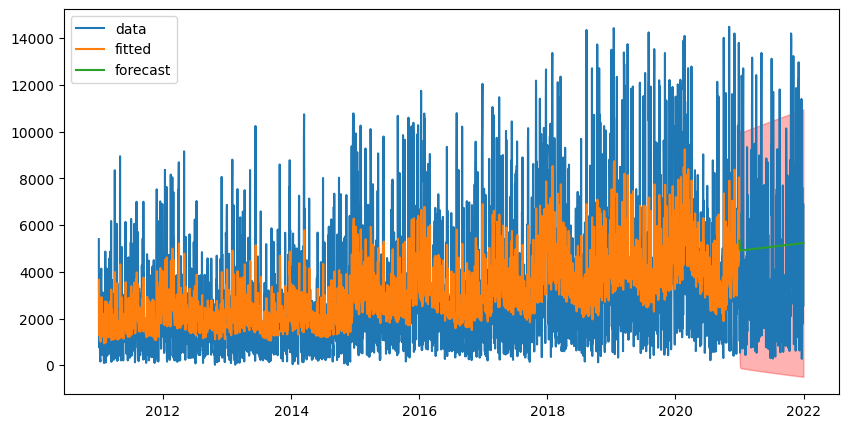

In [39]:
train_predictions = model.predict_in_sample(start=1, end=-1)

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(el_gr.index, el_gr['MW'], label='data')
ax.plot(train.index[1:], train_predictions, label='fitted')
ax.plot(test.index, test_predictions, label='forecast')
ax.fill_between(test.index, confidence_interval[:,0], confidence_interval[:, 1], color='red', alpha=0.3)
ax.legend();

In [105]:
df['MW'].std(ddof=1), df['MW'].mean()

(3045.9415911786873, 3183.5604806699766)

The root mean squared deviation turns out to be quite large, so the model does not reach peak (both up and down) values. And the predictions give only the trend, with very wide confidence intervals. That is, the model did not capture the seasonal component, and in addition - complete inability for long-term perspective.

In [94]:
import numpy as np
def rmse(t, y):
    return np.sqrt(np.mean((t-y)**2))

def mape(t, y):
    return np.mean(np.abs((t - y) / t)) * 100

In [41]:
mape(test['MW'], test_predictions)

174.83260355449198

The model caught the trend and that's it. We will try prophet, as there is clearly a seasonality expressed in years and a non-linear trend, prophet may show a +- decent result.

In [68]:
train = train.rename(index={'dt': 'ds'}, columns={'MW': 'y'})
test = test.rename(index={'dt': 'ds'}, columns={'MW': 'y'})

In [75]:
train.index = train.index.rename('ds')
test.index = test.index.rename('ds')

In [81]:
def transform_date(df: pd.DataFrame):
    df['index'] = list(range(df.shape[0]))
    df['ds'] = df.index
    df = df.set_index('index')
    df['ds'] = pd.to_datetime(df['ds'])
    return df

In [82]:
train = transform_date(train)
test = transform_date(test)

In [83]:
train.head()

,y,ds
index,,
0,518229.0,2011-01-01
1,83077.0,2011-01-02
2,73095.0,2011-01-03
3,376606.0,2011-01-04
4,216599.0,2011-01-05


In [84]:
m = prophet.Prophet()

In [85]:
m.fit(train)

22:38:33 - cmdstanpy - INFO - Chain [1] start processing
22:38:34 - cmdstanpy - INFO - Chain [1] done processing


In [86]:
future = m.make_future_dataframe(periods=365)
future.tail()

,ds
4012,2021-12-26
4013,2021-12-27
4014,2021-12-28
4015,2021-12-29
4016,2021-12-30


In [87]:
forecast = m.predict(future)

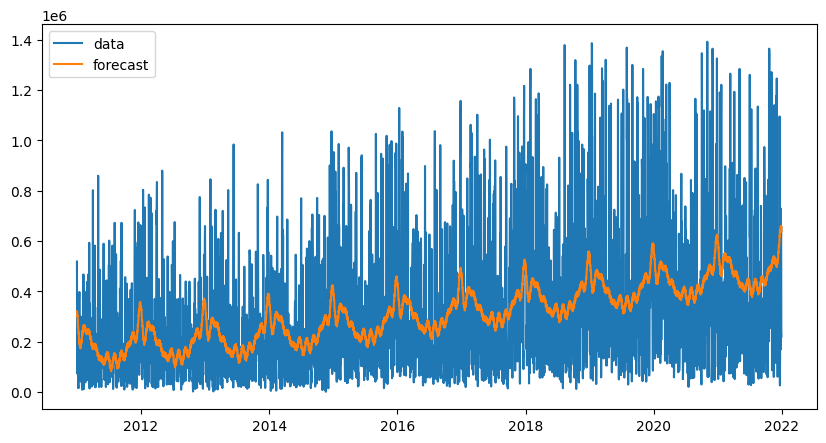

In [88]:
train_predictions = model.predict_in_sample(start=1, end=-1)

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(el_gr.index, el_gr['MW'], label='data')
# ax.plot(train.index[1:], train_predictions, label='fitted')
ax.plot(el_gr.index, forecast['yhat'], label='forecast')
# ax.fill_between(test.index, confidence_interval[:,0], confidence_interval[:, 1], color='red', alpha=0.3)
ax.legend();

In [96]:
from sklearn.metrics import mean_absolute_percentage_error

In [98]:
mean_absolute_percentage_error(forecast['yhat'][forecast.shape[0]-N_test:], test['y']) * 100

55.36302336315973

Here prophet has much better results: it caught the seasonal component and was able to continue it, and caught the trend as well. However, the variance of the original series is much higher than that of the predicted one, i.e. prophet weakly caught the variance. And the metric is significantly better.

When training sarima through pmdarima, I had some difficulties in the end and the first (the only one that worked) option may be bad and should not be looked at in this work: in the end, it was trained for more than half an hour and continued (before that, it caught errors of infinite output of training results of this first run, maybe the charm broke down, or maybe I broke something).